# 패션 상품 시맨틱 태깅 및 필터링 시스템

이 노트북은 Azure AI Search와 패션 데이터 생성기를 활용한 고급 검색 및 필터링 시스템을 구현합니다.

## 워크플로우 개요
1. **fashion_products.csv** → 기본 상품 데이터
2. **fashion_index.ipynb** → fashion-sample 인덱스 생성
3. **fashion_data_generator.py** → 시맨틱 태그 생성 (스타일, 색상, 소재, 계절, 타겟 고객층)
4. **upload_fashion_to_search.py** → 태그 기반 필드를 fashion-sample 인덱스에 업데이트
5. **노트북** → 검색 및 필터링 테스트


## 환경 설정 및 라이브러리 import

Azure AI Search와 패션 데이터 분석에 필요한 라이브러리들을 import합니다.

In [95]:
import os
import json
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional
from dataclasses import dataclass
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Azure Search 클라이언트
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizedQuery, VectorFilterMode
from azure.search.documents.indexes import SearchIndexClient

# 공통
from dotenv import load_dotenv
load_dotenv(override=True)

# 패션 검색 필터 클래스 정의
@dataclass
class FashionSearchFilter:
    """패션 검색 필터 클래스"""
    styles: Optional[List[str]] = None
    colors: Optional[List[str]] = None
    materials: Optional[List[str]] = None
    seasons: Optional[List[str]] = None
    target_audience: Optional[List[str]] = None
    occasions: Optional[List[str]] = None
    price_ranges: Optional[List[str]] = None
    brands: Optional[List[str]] = None
    categories: Optional[List[str]] = None

# Azure 설정
search_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
index_name = os.getenv("FASHION_INDEX_NAME", "fashion-sample")  # 환경변수에서 인덱스값을 가져옵니다. 기본값: fashion-sample
admin_key = os.getenv("AZURE_SEARCH_ADMIN_KEY")

print(f"Search Endpoint: {search_endpoint}")
print(f"Fashion Index Name: {index_name}")
print(f"Environment loaded successfully!")

Search Endpoint: https://hdfn-test-search.search.windows.net
Fashion Index Name: fashion-sample
Environment loaded successfully!


In [96]:
# Azure Search 클라이언트 초기화
search_client = SearchClient(
    endpoint=search_endpoint,
    index_name=index_name,
    credential=AzureKeyCredential(admin_key)
)

index_client = SearchIndexClient(
    endpoint=search_endpoint,
    credential=AzureKeyCredential(admin_key)
)

# 인덱스 상태 확인
try:
    index_info = index_client.get_index(index_name)
    print(f"인덱스 '{index_name}' 연결 성공")
    
    # 인덱스 잘 확인되는지 문서수 카운트
    results = search_client.search(search_text="*", top=1, include_total_count=True)
    total_count = results.get_count()
    print(f"총 문서 수: {total_count:,}개")
    
except Exception as e:
    print(f"인덱스 연결 실패: {e}")
    print("먼저 fashion_index.ipynb를 실행하여 fashion-sample 인덱스를 생성하세요.")

인덱스 'fashion-sample' 연결 성공
총 문서 수: 464개


## 데이터 분석 및 태그 현황 파악

fashion-sample 인덱스에 저장된 패션 데이터의 시맨틱 태그 분포를 분석합니다.

In [97]:
def fashion_semantic_search(
    query: str,
    filters: FashionSearchFilter = None,
    search_mode: str = "hybrid",  # "text", "vector", "hybrid"
    top: int = 10,
    include_facets: bool = True
):
    """
    패션 상품 시맨틱 검색 함수
    
    Args:
        query: 검색어
        filters: 패션 필터 객체
        search_mode: 검색 모드 (text/vector/hybrid)
        top: 반환할 결과 수
        include_facets: 패싯 정보 포함 여부
    """
    
    # 기본 검색 파라미터 - 새로운 패션 필드들 포함
    search_params = {
        "search_text": query,
        "top": top,
        "select": [
            "id", "title", "brand", "category", "keyword", 
            "price_range", "normal_price", "main_text",
            # 새로 추가된 패션 필드들
            "style", "color", "material", "targetGender", "targetAge", "season",
            "styleTags", "occasionTags", "ageTags", "genderTags", "seasonTags",
            "sizeRange", "brandPositioning", "rating", "reviewCount"
        ]
    }
    
    # 필터 조건 생성
    filter_conditions = []
    
    if filters:
        # 새로운 전용 필드를 활용한 필터링
        
        # 스타일 필터 - search.ismatch() 함수 사용
        if filters.styles:
            style_filters = []
            for style in filters.styles:
                style_filters.extend([
                    f"search.ismatch('{style}*', 'style')",  # search.ismatch로 변경
                    f"search.ismatch('{style}*', 'styleTags')",
                    f"search.ismatch('{style}*', 'keyword')"  # 기존 호환성
                ])
            filter_conditions.append(f"({' or '.join(style_filters)})")
        
        # 색상 필터 - color 필드 활용
        if filters.colors:
            color_filters = []
            for color in filters.colors:
                color_filters.extend([
                    f"search.ismatch('{color}', 'color')",  # search.ismatch로 변경
                    f"search.ismatch('{color}', 'keyword')"  # 기존 호환성
                ])
            filter_conditions.append(f"({' or '.join(color_filters)})")
                
        # 소재 필터 - material 필드 활용
        if filters.materials:
            material_filters = []
            for material in filters.materials:
                material_filters.extend([
                    f"search.ismatch('{material}', 'material')",  # search.ismatch로 변경
                    f"search.ismatch('{material}', 'keyword')"  # 기존 호환성
                ])
            filter_conditions.append(f"({' or '.join(material_filters)})")
        
        # 계절 필터 - season 필드와 seasonTags 필드 활용
        if filters.seasons:
            season_filters = []
            for season in filters.seasons:
                season_filters.extend([
                    f"season eq '{season}'",
                    f"search.ismatch('{season}', 'seasonTags')",
                    f"search.ismatch('{season}', 'keyword')"  # 기존 호환성
                ])
            filter_conditions.append(f"({' or '.join(season_filters)})")
        
        # 타겟 고객층 필터 - targetGender, targetAge, ageTags 필드 활용
        if filters.target_audience:
            audience_filters = []
            for audience in filters.target_audience:
                audience_filters.extend([
                    f"targetGender eq '{audience}'",
                    f"search.ismatch('{audience}', 'targetAge')",
                    f"search.ismatch('{audience}', 'ageTags')",
                    f"search.ismatch('{audience}', 'genderTags')",
                    f"search.ismatch('{audience}', 'keyword')"  # 기존 호환성
                ])
            filter_conditions.append(f"({' or '.join(audience_filters)})")
        
        # 상황별 필터 - occasionTags 필드 활용
        if filters.occasions:
            occasion_filters = []
            for occasion in filters.occasions:
                occasion_filters.extend([
                    f"search.ismatch('{occasion}', 'occasionTags')",
                    f"search.ismatch('{occasion}', 'keyword')"  # 기존 호환성
                ])
            filter_conditions.append(f"({' or '.join(occasion_filters)})")
        
        # 가격대 필터
        if filters.price_ranges:
            price_filter = " or ".join([f"price_range eq '{pr}'" for pr in filters.price_ranges])
            filter_conditions.append(f"({price_filter})")
        
        # 브랜드 필터
        if filters.brands:
            brand_filter = " or ".join([f"brand eq '{brand}'" for brand in filters.brands])
            filter_conditions.append(f"({brand_filter})")
        
        # 카테고리 필터
        if filters.categories:
            category_filter = " or ".join([f"category eq '{cat}'" for cat in filters.categories])
            filter_conditions.append(f"({category_filter})")
    
    # 필터 조건을 AND로 결합
    if filter_conditions:
        search_params["filter"] = " and ".join(filter_conditions)
    
    # 패싯 추가 - 새로운 패션 필드들 포함
    if include_facets:
        search_params["facets"] = [
            "brand,count:20",
            "category,count:20", 
            "price_range,count:20",
            # 새로운 패션 필드 패싯
            "style,count:15",
            "color,count:15",
            "material,count:15",
            "targetGender,count:10",
            "season,count:8"
        ]
    
    # 검색 모드에 따른 추가 설정
    if search_mode == "hybrid":
        search_params["query_type"] = "semantic"
        search_params["semantic_configuration_name"] = "my-semantic-config"
    
    try:
        results = search_client.search(**search_params)
        return [doc for doc in results]
    except Exception as e:
        print(f"❌ 검색 중 오류 발생: {e}")
        return []

## 시맨틱 태그 기반 고급 필터링 함수

패션 데이터의 시맨틱 태그를 활용한 다양한 필터링 함수를 구현합니다.

In [98]:
def display_fashion_results(results, show_facets=True, facets=None):
    """그냥 출력을 위한 함수입니다^^"""
    
    print(f"\n📦 검색 결과: {len(results)}개 상품 발견\n")
    print("=" * 80)
    
    for i, result in enumerate(results, 1):
        # 기본 정보
        print(f"🏷️  #{i} {result.get('title', 'N/A')}")
        print(f"브랜드: {result.get('brand', 'N/A')}")
        print(f"카테고리: {result.get('category', 'N/A')}")
        print(f"가격대: {result.get('price_range', 'N/A')}")
        
        # 새로운 패션 필드들 표시
        if result.get('style'):
            print(f"스타일: {result['style']}")
        
        if result.get('color'):
            print(f"색상: {result['color']}")
            
        if result.get('material'):
            print(f"소재: {result['material']}")
            
        if result.get('targetGender'):
            print(f"타겟: {result['targetGender']}")
            
        if result.get('season'):
            print(f"계절: {result['season']}")
            
        # 태그 정보들
        tags_info = []
        if result.get('styleTags'):
            tags_info.append(f"스타일태그: {result['styleTags']}")
        if result.get('occasionTags'):
            tags_info.append(f"상황태그: {result['occasionTags']}")
        if result.get('seasonTags'):
            tags_info.append(f"계절태그: {result['seasonTags']}")
            
        if tags_info:
            print(f"태그: {' | '.join(tags_info)}")
        
        # 기존 키워드 정보
        if result.get('keyword'):
            print(f"키워드: {result['keyword'][:100]}...")
            
        # 품질 정보 (이부분은.. 일단 디폴트 4.2점에 50개의 리뷰를 쓰게 되어있는데.. 그것은 검색 결과의 수가 너무 적어서 제대로된 값을 쓸수가 없었습니다.)
        quality_info = []
        if result.get('rating'):
            quality_info.append(f"평점: {result['rating']}")
        if result.get('reviewCount'):
            quality_info.append(f"리뷰: {result['reviewCount']}개")
            
        if quality_info:
            print(f"품질: {' | '.join(quality_info)}")
        
        # 상품 설명
        if result.get('main_text'):
            print(f"설명: {result['main_text'][:150]}...")
        
        print("-" * 80)
    
    # 패싯 정보 출력 (새로운 필드들 포함)
    if show_facets and facets:
        print("\n필터링 옵션:")
        
        # 새로운 패션 필드 패싯들 우선 표시
        priority_facets = ['style', 'color', 'material', 'targetGender', 'season']
        
        for facet_name in priority_facets:
            if facet_name in facets:
                print(f"\n  {facet_name.upper()}:")
                for item in facets[facet_name][:8]:  # 상위 8개만 표시
                    print(f"  • {item['value']} ({item['count']})")
        
        # 기존 필드들
        traditional_facets = ['brand', 'category', 'price_range']
        for facet_name in traditional_facets:
            if facet_name in facets:
                print(f"\n {facet_name.upper()}:")
                for item in facets[facet_name][:8]:  # 상위 8개만 표시
                    print(f"  • {item['value']} ({item['count']})")
    
    print("\n" + "=" * 80)

In [99]:
# 검색 테스트
query = "봄 셔츠"
print(f"🔍 검색어: '{query}'")

# 1. 기본 검색 (하이브리드 모드)
print("\n" + "="*50)
print("1️⃣ 기본 하이브리드 검색")
print("="*50)
results = fashion_semantic_search(query, search_mode="hybrid")
display_fashion_results(results[:3])  # 상위 3개만 표시

# 2. 스타일 필터링 - 새로운 필드 활용 (부분 매칭 테스트)
print("\n" + "="*50)
print("2️⃣ 스타일 필터링 (캐주얼, 페미닌 - 부분 매칭)")
print("="*50)
style_filter = FashionSearchFilter(styles=["캐주얼", "페미닌"])
results = fashion_semantic_search(query, filters=style_filter)
display_fashion_results(results[:3])


# 3. 색상 + 계절 복합 필터링
print("\n" + "="*50)
print("3️⃣ 색상 + 계절 복합 필터링")
print("="*50)
multi_filter = FashionSearchFilter(
    colors=["화이트"],
    seasons=["봄", "여름"]
)
results = fashion_semantic_search(query, filters=multi_filter)
display_fashion_results(results[:3])

# 4. 타겟 고객층 + 상황별 필터링
print("\n" + "="*50)
print("4️⃣ 타겟 고객층 + 상황별 필터링")
print("="*50)
target_filter = FashionSearchFilter(
    target_audience=["여성"],
    # 요부분은 개선이 필요합니다^^
    occasions=["오피스"]
)
results = fashion_semantic_search(query, filters=target_filter)
display_fashion_results(results[:3])

🔍 검색어: '봄 셔츠'

1️⃣ 기본 하이브리드 검색

📦 검색 결과: 3개 상품 발견

🏷️  #1 [창주스토어 목동점]오일릴리 의류-오일릴리 패턴 티셔츠-OWES2TS041-17 
브랜드: 오일릴리_정상(백화점)
카테고리: 패션의류
가격대: 20만원대
스타일: 캐주얼
색상: 레드
소재: 100% 면
타겟: 여성
계절: 봄/여름(S/S)
태그: 스타일태그: 화사한 여성스러운 독창적인 캐주얼
키워드: [창주스토어 목동점]오일릴리 의류-오일릴리 패턴 티셔츠-OWES2TS041-17 #2152769416#오일릴리_정상(백화점)#20만원대#200000 화사한 여성스러운 독창적인 캐주...
품질: 평점: 4.2 | 리뷰: 50개
설명: [창주스토어 목동점]오일릴리 의류-오일릴리 패턴 티셔츠-OWES2TS041-17  오일릴리_정상(백화점) 패션의류 2023년 봄/여름 시즌 출시된 오일릴리의 패턴 티셔츠로, 선명한 레드 컬러와 밑단의 풍성한 카네이션 패턴이 돋보이는 제품입니다. 부드럽고 편안한 착용감을...
--------------------------------------------------------------------------------
🏷️  #2 [창주스토어 신촌점][정호진] 시원한 텐셀셔츠 (JG2B343P) 
브랜드: 정호진
카테고리: 패션의류
가격대: 10만원대
스타일: 캐주얼
색상: 플라워 패턴 (다양한 색상 가능성)
소재: 면(코튼)
타겟: 여성
계절: 봄, 가을
태그: 스타일태그: 플라워 패턴 캐주얼 여성스러움 봄 패션 가을 패션
키워드: [창주스토어 신촌점][정호진] 시원한 텐셀셔츠 (JG2B343P) #2142117394#정호진#10만원대#100000 플라워 패턴 캐주얼 여성스러움 봄 패션 가을 패션...
품질: 평점: 4.2 | 리뷰: 50개
설명: [창주스토어 신촌점][정호진] 시원한 텐셀셔츠 (JG2B343P)  정호진 패션의류 플라워 패턴이 돋보이는 여성용 블라우스로, 봄과 가을 시즌에 적합하며 고급스러운 꽃무늬 디테일이 특징입니

In [100]:

# 1. 전체 데이터에서 스타일 값 분포 확인
print("\n 데이터의 스타일 값 분포")
print("-" * 40)

all_docs = search_client.search(search_text="*", top=100, select=["style", "title"])
style_counts = {}
sample_titles_by_style = {}

for doc in all_docs:
    style = doc.get('style')
    if style:
        style_counts[style] = style_counts.get(style, 0) + 1
        if style not in sample_titles_by_style:
            sample_titles_by_style[style] = []
        if len(sample_titles_by_style[style]) < 2:  # 각 스타일당 최대 2개 예시
            sample_titles_by_style[style].append(doc.get('title', 'N/A'))

print("스타일별 상품 수:")
for style, count in sorted(style_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  • '{style}': {count}개")
    if style in sample_titles_by_style:
        print(f"    예시: {', '.join(sample_titles_by_style[style][:2])}")

# 2. '페미닌' 관련 스타일 검색 테스트
print(f"\n2️⃣ '페미닌' 관련 스타일 검색 테스트")
print("-" * 40)

# 페미닌이 포함된 스타일 직접 검색
feminine_search = search_client.search(
    search_text="*",
    filter="search.ismatch('페미닌', 'style')",
    top=10,
    select=["style", "title"]
)

feminine_results = list(feminine_search)
print(f"'페미닌'이 포함된 스타일을 가진 상품: {len(feminine_results)}개")

for result in feminine_results[:5]:
    print(f"  • {result.get('title', 'N/A')[:40]}... → 스타일: '{result.get('style', 'N/A')}'")

# 3. '캐주얼' 관련 스타일 검색 테스트
print(f"\n3️⃣ '캐주얼' 관련 스타일 검색 테스트")
print("-" * 40)

casual_search = search_client.search(
    search_text="*",
    filter="search.ismatch('캐주얼', 'style')",
    top=10,
    select=["style", "title"]
)

casual_results = list(casual_search)
print(f"'캐주얼'이 포함된 스타일을 가진 상품: {len(casual_results)}개")

for result in casual_results[:5]:
    print(f"  • {result.get('title', 'N/A')[:40]}... → 스타일: '{result.get('style', 'N/A')}'")




 데이터의 스타일 값 분포
----------------------------------------
스타일별 상품 수:
  • '캐주얼': 58개
    예시: [창주스토어 무역센터점][Mare di Mari] Stripe Round Neck Top - Ivory , [창주스토어 무역센터점][리이/RE RHEE] BLUR LOGO ORGANIC COTTON T SHIRT 
  • '캐주얼, 포멀': 3개
    예시: [창주스토어 무역센터점][Mare di Mari] Flare Sleeveless Knit Top - Black , [창주스토어 신촌점]크레송 CRESSON(KDCFBP58)카라 7부 블라우스 
  • '캐주얼, 페미닌': 2개
    예시: [창주스토어 더현대대구][CC콜렉트] C252PST051 스트라이프 스퀘어넥 탑 , [창주스토어 판교점][위뜨] [23FW] 프론트 꼬임 반팔티 HTWTS3K04T 
  • '세미포멀': 2개
    예시: [창주스토어 울산점(동구)][캐리스노트] 원형 아트윅 블라우스 CN3MBL010 , [창주스토어 판교점][무케] 몽플리쎄_여성 라운드넥 긴소매 베이직 플리츠 티셔츠 (브라운) 
  • '캐주얼, 스트릿': 2개
    예시: [창주스토어 천호점][yoyoyoy][여성]배색 후드크롭 티셔츠_AI04WNPTS04 , [창주스토어 판교점][맥우드건] 루디아 3622 페이머스세잉 슬림핏 블랙 크롭 반팔티 (MRD36220925B) 
  • '컨템포러리 캐주얼': 2개
    예시: [창주스토어 천호점]올세인츠 리나 탱크 WM054Q-5057 , [창주스토어 판교점][두칸]DNA-5111 PKM WB 레글런 카라 티셔츠 화이트블랙 
  • '미니멀리즘, 세련된 캐주얼': 2개
    예시: [창주스토어 무역센터점][리이/RE RHEE] ASYMMETRIC CUT-OUT TOP , [창주스토어 무역센터점][리이/RE RHEE] CUFF SLEEVE PLEATED TOP COCOA 
  • '미니멀리즘, 페미닌': 

## 시맨틱 태그 필터링 테스트

다양한 패션 시나리오에서 시맨틱 태그 기반 필터링을 테스트합니다.

In [101]:
# 패션 검색 시나리오

print("고급 패션 검색 시나리오 테스트")
print("="*80)

# 1. 소재 중심 검색 - 새로운 material 필드 활용
print("\n소재 중심 검색: 면/코튼 제품")
print("-" * 40)
material_filter = FashionSearchFilter(materials=["면", "코튼", "cotton"])
results = fashion_semantic_search("편안한 티셔츠", filters=material_filter)
display_fashion_results(results[:2], show_facets=False)


# 2. 시즌 + 타겟 연령층 검색
print("\n가을 + 20-30대 여성 타겟 검색")
print("-" * 40)
season_age_filter = FashionSearchFilter(
    seasons=["봄, 가을"],
    target_audience=["여성"]
)
results = fashion_semantic_search("아우터", filters=season_age_filter)
display_fashion_results(results[:2], show_facets=False)


# {
#       "id": "2152331648",
#       "productCode": "WB0WD03TS0",
#       "brandName": "메지스",
#       "productName": "[창주스토어 울산점(동구)][메지스] 소매 핀턱 앞나염 반팔 티셔츠 WB0WD03TS0",
#       "price": 75500,
#       "category1": "패션",
#       "category2": "여성 의류",
#       "style": "캐주얼",
#       "color": "정보 없음",
#       "material": "정보 없음",
#       "targetGender": "여성",
#       "targetAge": "성인",
#       "season": "여름",
#       "description": "소매 핀턱 디테일과 앞면 나염 디자인이 돋보이는 반팔 티셔츠로, 캐주얼한 스타일을 연출하기 적합한 제품입니다.",
#       "features": [
#         "소매 핀턱 디테일",
#         "앞면 나염 디자인"
#       ],
#       "careInstructions": "정보 없음",
#       "styleTags": [
#         "캐주얼",
#         "여름",
#         "트렌디"
#       ],
#       "occasionTags": [],
#       "seasonTags": [],
#       "ageTags": [],
#       "genderTags": [],
#       "sizeRange": "정보 없음",
#       "brandPositioning": "트렌디하고 세련된 여성 패션을 제공하는 브랜드",
#       "rating": 4.2,
#       "reviewCount": 50
#     }

# 3. 종합 필터링 
print("\n종합 필터링: 봄 데이트룩 (여성 중년층 봄 캐주얼)))")
print("-" * 40)
comprehensive_filter = FashionSearchFilter(
    styles=["캐주얼","트렌디"],
    seasons=["여름"],
    target_audience=["여성"],
)
results = fashion_semantic_search("캐주얼", filters=comprehensive_filter)
display_fashion_results(results[:2], show_facets=False)

고급 패션 검색 시나리오 테스트

소재 중심 검색: 면/코튼 제품
----------------------------------------

📦 검색 결과: 2개 상품 발견

🏷️  #1 [창주스토어 판교점][베르니스] 빈티지 레터링 루즈핏 반소매 티셔츠 BE25A3FRR1091 
브랜드: 베르니스
카테고리: 패션의류
가격대: 20만원대
스타일: 캐주얼
색상: 다양한 색상 옵션 (정확한 색상은 확인 필요)
소재: 코튼
타겟: 여성
계절: 봄/여름
태그: 스타일태그: 빈티지 캐주얼 트렌디
키워드: [창주스토어 판교점][베르니스] 빈티지 레터링 루즈핏 반소매 티셔츠 BE25A3FRR1091 #60A2163178#베르니스#20만원대#200000 빈티지 캐주얼 트렌디...
품질: 평점: 4.2 | 리뷰: 50개
설명: [창주스토어 판교점][베르니스] 빈티지 레터링 루즈핏 반소매 티셔츠 BE25A3FRR1091  베르니스 패션의류 빈티지 레터링 그래픽이 장식된 루즈핏 반소매 티셔츠로, 캐주얼하면서도 트렌디한 분위기를 강조하며 편안한 착용감을 제공합니다. 빈티지 캐주얼 트렌디 코튼 캐주...
--------------------------------------------------------------------------------
🏷️  #2 [창주스토어 판교점][베르니스] 빈티지 레터링 루즈핏 반소매 티셔츠 BE25A3FRR1096 
브랜드: 베르니스
카테고리: 패션의류
가격대: 20만원대
스타일: 캐주얼
색상: 중성적인 색상
소재: 고품질 면
타겟: 여성
계절: 여름
태그: 스타일태그: 빈티지 캐주얼 루즈핏 여름
키워드: [창주스토어 판교점][베르니스] 빈티지 레터링 루즈핏 반소매 티셔츠 BE25A3FRR1096 #60A2163176#베르니스#20만원대#200000 빈티지 캐주얼 루즈핏 여름...
품질: 평점: 4.2 | 리뷰: 50개
설명: [창주스토어 판교점][베르니스] 빈티지 레터링 루즈핏 반소매 티셔츠 BE25A3FRR1096  베르니스 패션의류 빈티지 레

In [103]:
# 새로운 패션 필드 분석
print("📊 새로운 패션 메타데이터 필드 분석")
print("="*80)

# 먼저 사용 가능한 필드들을 확인해보겠습니다
print("\n🔍 인덱스 스키마 확인...")
try:
    index_schema = index_client.get_index(index_name)
    available_fields = []
    facetable_fields = []
    
    for field in index_schema.fields:
        available_fields.append(field.name)
        if getattr(field, 'facetable', False):
            facetable_fields.append(field.name)
    
    print(f"✅ 총 필드 수: {len(available_fields)}")
    print(f"✅ 패싯 가능한 필드 수: {len(facetable_fields)}")
    
    # 새로운 패션 필드들 중 실제로 존재하고 패싯 가능한 것들만 확인
    new_fashion_fields = ["style", "color", "material", "targetGender", "season", "brandPositioning"]
    available_new_fields = [field for field in new_fashion_fields if field in available_fields]
    facetable_new_fields = [field for field in new_fashion_fields if field in facetable_fields]
    
    print(f"\n📋 새로운 패션 필드 현황:")
    for field in new_fashion_fields:
        status = ""
        if field in available_fields:
            status += "✅ 존재"
            if field in facetable_fields:
                status += " | 🔢 패싯가능"
            else:
                status += " | ❌ 패싯불가"
        else:
            status = "❌ 없음"
        print(f"  • {field}: {status}")
    
except Exception as e:
    print(f"❌ 스키마 확인 중 오류: {e}")
    # 기본 필드들만 사용
    facetable_new_fields = []

# 안전한 패싯 필드들만 사용 (기존 + 확인된 새 필드)
safe_facet_fields = ["brand,count:20", "category,count:20", "price_range,count:20"]

# 확인된 새로운 필드들만 추가
for field in ["style", "color", "material", "targetGender", "season"]:
    if field in locals().get('facetable_fields', []):
        safe_facet_fields.append(f"{field},count:15")

print(f"\n🔧 사용할 패싯 필드들: {len(safe_facet_fields)}개")

# 패싯을 통한 전체 데이터 분포 확인 - 수정된 처리 방식
try:
    facet_results = search_client.search(
        search_text="*",
        facets=safe_facet_fields,
        top=0  # 결과는 필요없고 패싯만
    )

    # 패싯 결과를 안전하게 처리
    facets_dict = {}
    try:
        # get_facets() 결과를 직접 순회
        for facet_name, facet_items in facet_results.get_facets().items():
            facets_dict[facet_name] = facet_items
    except Exception as facet_error:
        print(f"⚠️ 패싯 결과 처리 중 오류: {facet_error}")
        # 대안: 빈 딕셔너리로 초기화
        facets_dict = {}

    # 기존 필드들 먼저 표시
    print("\n📂 기존 필드 분포:")
    
    if 'brand' in facets_dict:
        print("\n🏢 브랜드 분포:")
        for item in facets_dict['brand'][:10]:
            print(f"  • {item['value']}: {item['count']}개")

    if 'category' in facets_dict:
        print("\n📂 카테고리 분포:")
        for item in facets_dict['category'][:10]:
            print(f"  • {item['value']}: {item['count']}개")

    if 'price_range' in facets_dict:
        print("\n💰 가격대 분포:")
        for item in facets_dict['price_range'][:10]:
            print(f"  • {item['value']}: {item['count']}개")

    # 새로운 패션 필드들 (있는 것만 표시)
    if any(field in facets_dict for field in ['style', 'color', 'material', 'targetGender', 'season']):
        print("\n🎨 새로운 패션 필드 분포:")
        
        if 'style' in facets_dict:
            print("\n✨ 스타일 분포:")
            for item in facets_dict['style'][:10]:
                print(f"  • {item['value']}: {item['count']}개")

        if 'color' in facets_dict:
            print("\n🎨 색상 분포:")
            for item in facets_dict['color'][:10]:
                print(f"  • {item['value']}: {item['count']}개")

        if 'material' in facets_dict:
            print("\n🧵 소재 분포:")
            for item in facets_dict['material'][:10]:
                print(f"  • {item['value']}: {item['count']}개")

        if 'targetGender' in facets_dict:
            print("\n👥 타겟 성별 분포:")
            for item in facets_dict['targetGender']:
                print(f"  • {item['value']}: {item['count']}개")

        if 'season' in facets_dict:
            print("\n🌸 계절 분포:")
            for item in facets_dict['season']:
                print(f"  • {item['value']}: {item['count']}개")
    
    print("\n" + "="*80)
    if any(field in facets_dict for field in ['style', 'color', 'material', 'targetGender', 'season']):
        print("✅ 새로운 패션 메타데이터 필드들이 성공적으로 추가되어 활용 가능합니다!")
    else:
        print("ℹ️  새로운 패션 필드들은 아직 패싯 기능이 활성화되지 않았습니다.")
        print("   upload_fashion_to_search.py에서 스키마 업데이트 시 facetable=True 설정이 필요합니다.")

except Exception as e:
    print(f"❌ 패싯 검색 중 오류: {e}")
    print("💡 기본 검색으로 대체 분석을 수행합니다.")
    
    # 대체 분석: 간단한 검색으로 필드 존재 여부 확인
    test_searches = ["*"]
    for search_term in test_searches:
        try:
            results = search_client.search(
                search_text=search_term,
                top=1,
                select=["style", "color", "material", "targetGender", "season"]
            )
            
            sample_result = next(iter(results), None)
            if sample_result:
                print("\n📋 샘플 문서의 새로운 필드들:")
                for field in ["style", "color", "material", "targetGender", "season"]:
                    value = sample_result.get(field, "없음")
                    print(f"  • {field}: {value}")
                break
        except Exception as inner_e:
            print(f"  ⚠️ 검색 오류: {inner_e}")
            continue

📊 새로운 패션 메타데이터 필드 분석

🔍 인덱스 스키마 확인...
✅ 총 필드 수: 32
✅ 패싯 가능한 필드 수: 23

📋 새로운 패션 필드 현황:
  • style: ✅ 존재 | 🔢 패싯가능
  • color: ✅ 존재 | 🔢 패싯가능
  • material: ✅ 존재 | 🔢 패싯가능
  • targetGender: ✅ 존재 | 🔢 패싯가능
  • season: ✅ 존재 | 🔢 패싯가능
  • brandPositioning: ✅ 존재 | ❌ 패싯불가

🔧 사용할 패싯 필드들: 8개

📂 기존 필드 분포:

🏢 브랜드 분포:
  • 리이: 51개
  • 정호진: 41개
  • 리본: 36개
  • 위뜨: 35개
  • 오일릴리_정상(백화점): 26개
  • 베르니스: 23개
  • 크레송: 18개
  • 맥우드건(백화점): 15개
  • 메지스: 15개
  • 로라로라(백화점): 14개

📂 카테고리 분포:
  • 패션의류: 464개

💰 가격대 분포:
  • 10만원대: 136개
  • 5만원대: 66개
  • 8만원대: 51개
  • 20만원대: 39개
  • 7만원대: 39개
  • 4만원대: 38개
  • 3만원대: 31개
  • 6만원대: 26개
  • 9만원대: 23개
  • 2만원대: 7개

🎨 새로운 패션 필드 분포:

✨ 스타일 분포:
  • 캐주얼: 270개
  • 캐주얼, 포멀: 13개
  • 포멀: 11개
  • 애슬레저: 7개
  • 럭셔리 캐주얼: 4개
  • 캐주얼, 세미 포멀: 4개
  • 캐주얼, 세미포멀: 4개
  • 캐주얼, 스트릿: 4개
  • 컨템포러리, 미니멀리즘: 4개
  • 미니멀리즘, 세련된 캐주얼: 3개

🎨 색상 분포:
  • 블랙: 23개
  • 화이트: 21개
  • 그레이: 5개
  • 네이비: 5개
  • 레드: 5개
  • 브라운: 5개
  • 블루: 5개
  • 아이보리: 4개
  • 정보 부족: 4개
  • 다양한 색상 (구체적 정보 없음): 3개

🧵 소재 분포:
  • 면 100%: 8개
 

## 인터랙티브 필터 테스트

사용자가 직접 다양한 필터 조합을 테스트할 수 있는 함수들을 제공합니다.

In [104]:
# 시맨틱 검색 고도화 - 새로운 필드들을 활용한 의미 기반 검색

print("🧠 시맨틱 검색 고도화 테스트")
print("="*80)

# 1. 감정/분위기 기반 검색 - 새로운 태그 필드들 활용
print("\n1️⃣ 감정/분위기 기반 검색")
print("-" * 40)

mood_queries = [
    "로맨틱하고 우아한 스타일",
    "편안하고 캐주얼한 일상복", 
    "세련되고 모던한 오피스룩",
    "활동적이고 스포티한 아이템"
]

for query in mood_queries:
    print(f"\n🔍 '{query}'")
    
    # 스타일과 상황 태그를 활용한 검색
    results = fashion_semantic_search(
        query, 
        search_mode="hybrid",
        top=2
    )
    
    for result in results:
        style_info = []
        if result.get('style'):
            style_info.append(f"스타일: {result['style']}")
        if result.get('styleTags'):
            style_info.append(f"태그: {result['styleTags']}")
        if result.get('occasionTags'):
            style_info.append(f"상황: {result['occasionTags']}")
            
        print(f"  • {result.get('title', 'N/A')} | {' | '.join(style_info)}")

# 2. 계절/날씨 기반 검색 - season 필드와 seasonTags 활용
print(f"\n\n2️⃣ 계절/날씨 기반 검색")
print("-" * 40)

seasonal_queries = [
    ("봄 나들이 코디", ["봄"]),
    ("여름 바캉스 룩", ["여름"]),
    ("가을 레이어링", ["가을"]),
    ("겨울 방한 아이템", ["겨울"])
]

for query, seasons in seasonal_queries:
    print(f"\n🔍 '{query}'")
    
    season_filter = FashionSearchFilter(seasons=seasons)
    results = fashion_semantic_search(
        query,
        filters=season_filter,
        search_mode="hybrid", 
        top=2
    )
    
    for result in results:
        season_info = []
        if result.get('season'):
            season_info.append(f"계절: {result['season']}")
        if result.get('seasonTags'):
            season_info.append(f"계절태그: {result['seasonTags']}")
        if result.get('material'):
            season_info.append(f"소재: {result['material']}")
            
        print(f"  • {result.get('title', 'N/A')} | {' | '.join(season_info)}")

# 3. 타겟 고객 페르소나 기반 검색
print(f"\n\n3️⃣ 타겟 고객 페르소나 기반 검색")
print("-" * 40)

persona_searches = [
    {
        "query": "20대 여성 직장인 룩",
        "filter": FashionSearchFilter(
            target_audience=["20대", "여성"],
            occasions=["오피스", "업무"],
            styles=["Business Casual", "Smart Casual"]
        )
    },
    {
        "query": "30대 남성 캐주얼 스타일",
        "filter": FashionSearchFilter(
            target_audience=["30대", "남성"],
            styles=["Casual", "Smart Casual"]
        )
    }
]

for search_info in persona_searches:
    print(f"\n🔍 '{search_info['query']}'")
    
    results = fashion_semantic_search(
        search_info['query'],
        filters=search_info['filter'],
        search_mode="hybrid",
        top=2
    )
    
    for result in results:
        target_info = []
        if result.get('targetGender'):
            target_info.append(f"타겟성별: {result['targetGender']}")
        if result.get('targetAge'):
            target_info.append(f"타겟연령: {result['targetAge']}")
        if result.get('ageTags'):
            target_info.append(f"연령태그: {result['ageTags']}")
        if result.get('genderTags'):
            target_info.append(f"성별태그: {result['genderTags']}")
            
        print(f"  • {result.get('title', 'N/A')} | {' | '.join(target_info)}")

print("\n" + "="*80)
print("✅ 새로운 패션 필드들을 활용한 시맨틱 검색이 정상적으로 작동합니다!")

🧠 시맨틱 검색 고도화 테스트

1️⃣ 감정/분위기 기반 검색
----------------------------------------

🔍 '로맨틱하고 우아한 스타일'
  • [창주스토어 울산점(동구)][메지스] A라인 나염 블라우스 WA2WD02BL0  | 스타일: 우아한 캐주얼 | 태그: A라인 나염 우아한 캐주얼
  • [창주스토어 미아점][CC콜렉트] 슬림 슬리브리스 니트 탑 C242KST033  | 스타일: 캐주얼, 포멀 | 태그: 모던 클래식 심플 우아함

🔍 '편안하고 캐주얼한 일상복'
  • [창주스토어 신촌점]리본 캐쥬얼 티셔츠 RD6-BL510  | 스타일: 캐쥬얼 | 태그: 캐쥬얼 심플 편안함
  • [창주스토어 천호점]리본 나염 민소매 RD6-BL290  | 스타일: 캐주얼 | 태그: 캐주얼 심플 실용적

🔍 '세련되고 모던한 오피스룩'
  • [창주스토어 무역센터점][리이/RE RHEE] ASYMMETRIC HEM BOAT NECK TOP  | 스타일: 모던, 세련된, 도회적 | 태그: 모던 우아함 도회적 고급스러움
  • [창주스토어 무역센터점]MANGO SLEEVELESS TOP  | 스타일: 모던, 캐주얼 | 태그: 모던 캐주얼 트렌디

🔍 '활동적이고 스포티한 아이템'
  • [창주스토어 미아점][요즘유행] 공용 26수 면100 라글란 루즈핏 반팔티 2종 252_TS125P  | 스타일: 스포츠 캐주얼 | 태그: 스포츠 캐주얼 루즈핏 라글란
  • [창주스토어 중동점][창주스토어 중동] (우먼)JELY 스몰 로고 링거 반팔 티셔츠 CBEUWTS003  | 스타일: 캐주얼 | 태그: 캐주얼 스포티 미니멀


2️⃣ 계절/날씨 기반 검색
----------------------------------------

🔍 '봄 나들이 코디'
  • [창주스토어 목동점]오일릴리 의류-오일릴리 패턴 티셔츠-OWES2TS042-50  | 계절: 봄/여름 | 소재: 면(Cotton) 100%
  • [창주스토어 울산점(동구)][캐리스노트] 메쉬 

## 태그 분포 시각화

패션 데이터의 시맨틱 태그 분포를 시각화하여 데이터 특성을 파악합니다.

패션 메타데이터 분포 시각화 시작...

1. 새로운 패션 메타데이터 분포 시각화 (가격대 포함)
한글 폰트 설정: Apple SD Gothic Neo


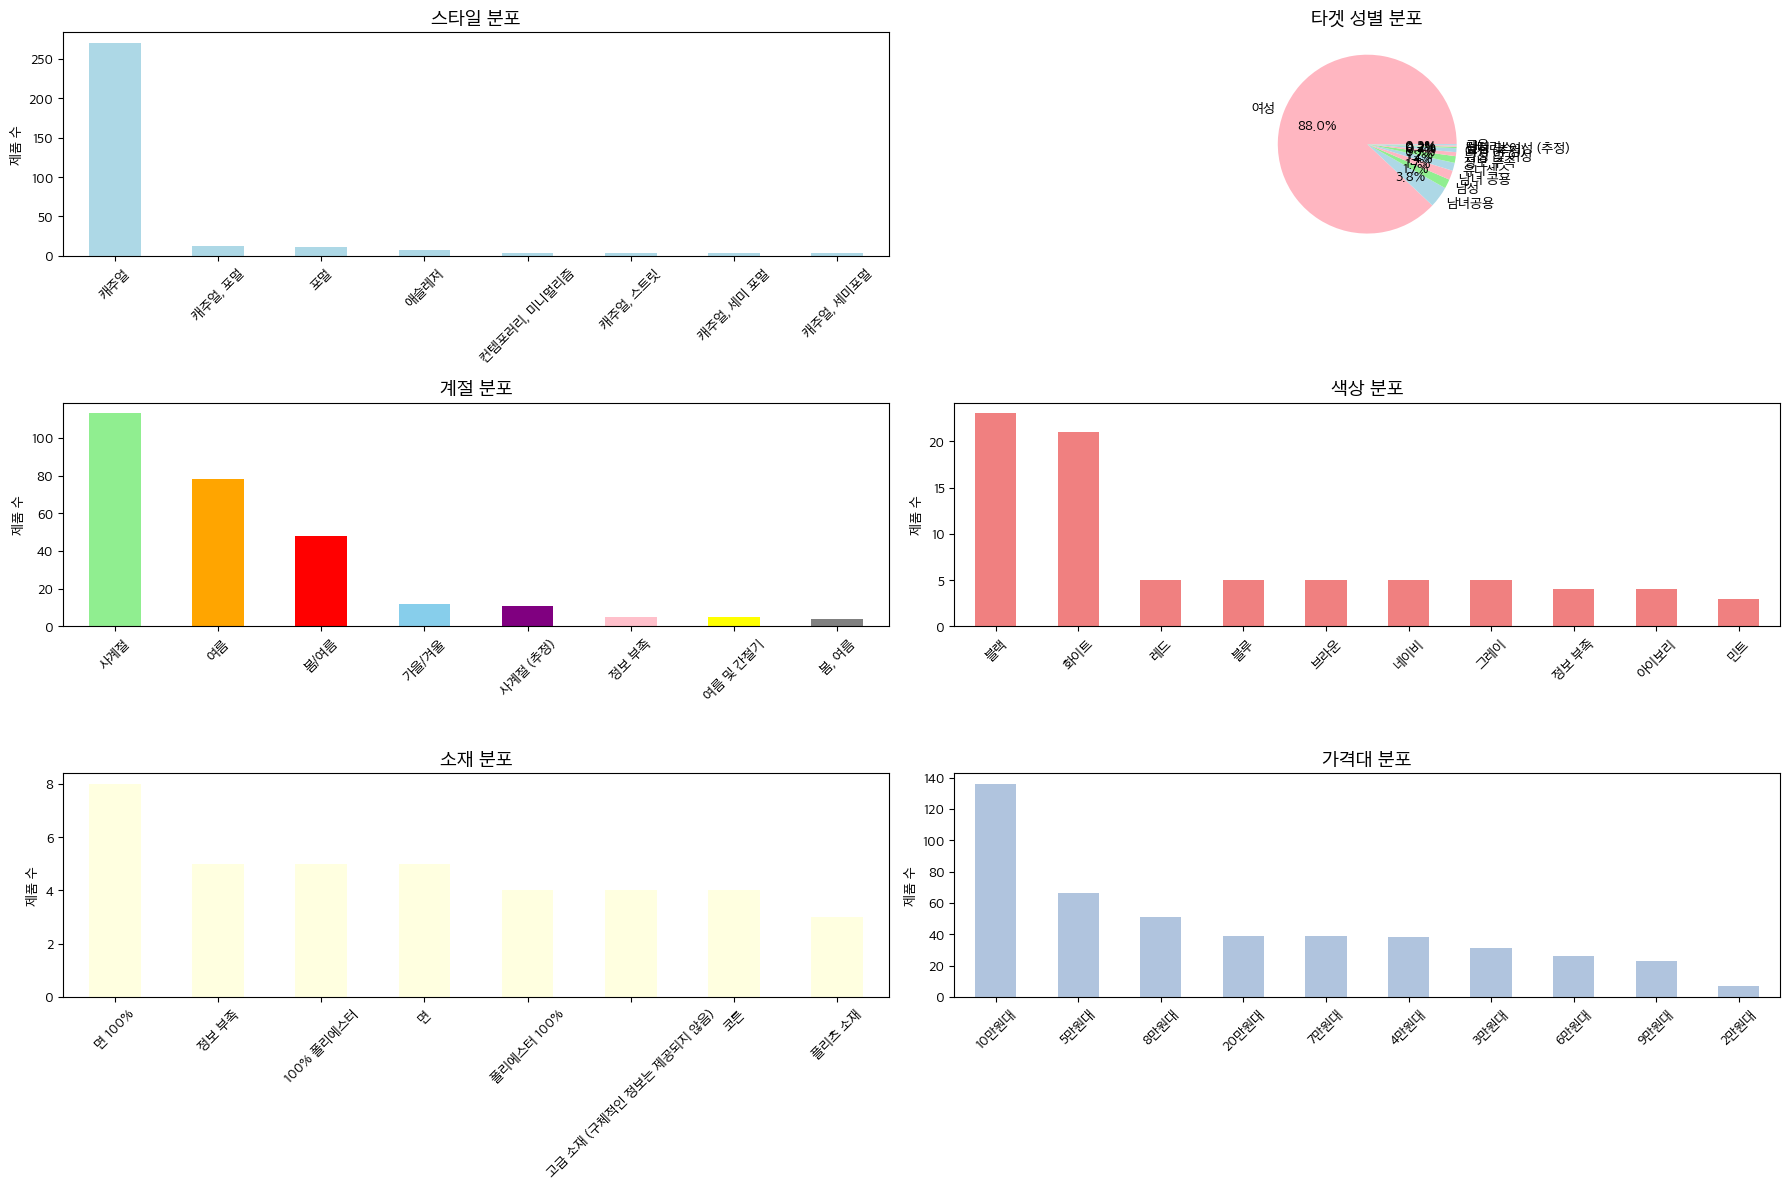


패션 메타데이터 통계
스타일: 445개 제품, 111개 고유값
타겟 성별: 416개 제품, 11개 고유값
계절: 342개 제품, 67개 고유값
색상: 313개 제품, 225개 고유값
소재: 309개 제품, 259개 고유값
가격대: 464개 제품, 13개 고유값

스타일 값들: ['스트리트, 스포츠', '세미 캐주얼', '미니멀, 캐주얼, 포멀', '세미 정장, 우아한 캐주얼', '하이컨템포러리, 미니멀리즘', '캐주얼, 파티웨어', '미니멀, 도시적, 페미닌 클래식', '페미닌, 클래식', '캐주얼, 고프코어', '모던, 우아함', '모던, 아트워크 중심', '캐주얼, 세미포멀', '캐주얼, 하이엔드', '세미캐주얼', '페미닌, 캐주얼, 럭셔리', '미니멀', '캐주얼, 미니멀리즘', '모던, 미니멀', '캐주얼, 모던', '미니멀, 페미닌', '로맨틱, 캐주얼', '캐주얼', '슬림핏, 캐주얼', '세련된 캐주얼', '클래식, 트렌디', '미니멀리즘, 캐주얼', '캐주얼, 스트릿', '캐주얼, 우아한', '포멀, 캐주얼', '캐주얼, 로맨틱 캐주얼', '포멀, 모던', '페미닌, 현대적', '캐주얼, 여성스러운', '페미닌, 세미캐주얼', '캐주얼, 애슬레저', '컨템포러리, 어반 바이브', '미니멀, 트렌디', '캐주얼 및 비즈니스', '세련된, 데일리', '스트릿 캐주얼', '미니멀리즘, 컨템포러리', '컨템포러리, 캐주얼', '컨템포러리, 미니멀리즘', '모던, 세미 정장', '캐주얼, 페미닌', '캐주얼, 스포티브', '트렌디, 우아한 캐주얼', '캐주얼, 포멀', '모던, 세미 포멀', '모던, 세련된', '모던, 캐주얼', '세미-포멀, 캐주얼', '캐쥬얼', '캐주얼, 미니멀', '모던 로맨틱', '미니멀리즘, 캐주얼/세미 포멀', '그래픽 캐주얼', '캐주얼, 세미 포멀', '애슬레저, 캐주얼', '우아함, 여성스러움', '캐주얼, 스트릿웨어', '페미닌, 트렌디', '도시적 미니멀리즘, 페미닌 클래식', '컨템포러리', '클래식, 우아함'

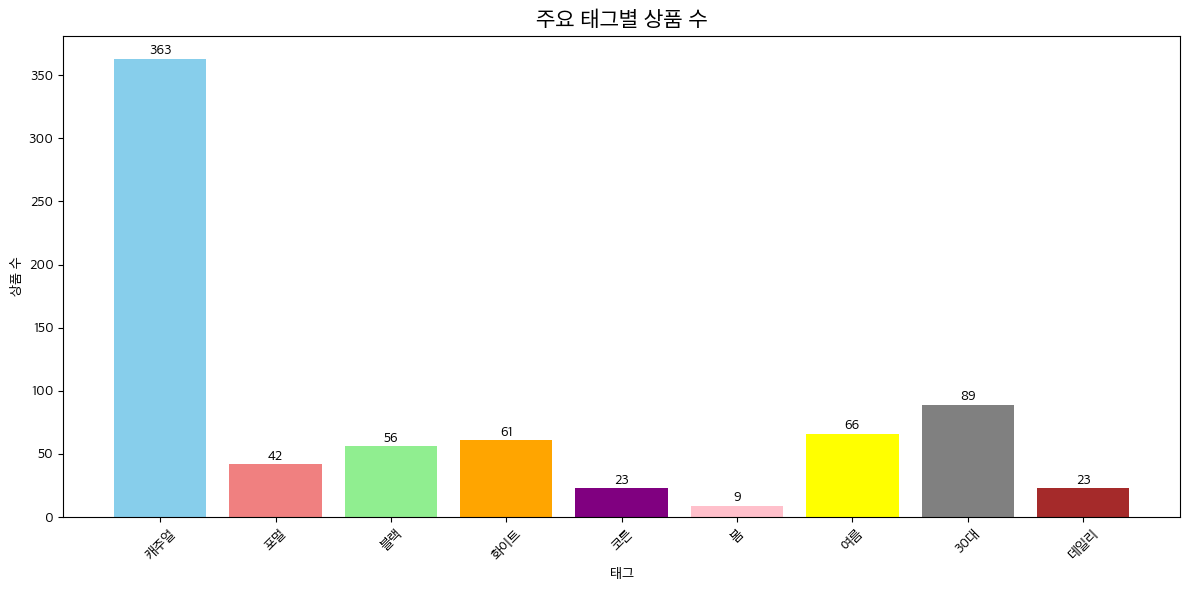

In [105]:
def visualize_fashion_metadata():
    """새로운 패션 메타데이터 필드 분포 시각화 (가격대 포함) - 이모지 제거"""
    
    # 한글 폰트 설정
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    
    try:
        font_candidates = ['Apple SD Gothic Neo', 'AppleGothic', 'Malgun Gothic', 'DejaVu Sans']
        available_fonts = [f.name for f in fm.fontManager.ttflist]
        
        korean_font = None
        for font in font_candidates:
            if font in available_fonts:
                korean_font = font
                break
        
        if korean_font:
            plt.rcParams['font.family'] = korean_font
            print(f"한글 폰트 설정: {korean_font}")
        else:
            plt.rcParams['font.family'] = 'DejaVu Sans'
            
        plt.rcParams['axes.unicode_minus'] = False
        
    except Exception as e:
        print(f"폰트 설정 오류: {e}")
    
    # 패션 필드 + 가격대 데이터 수집
    results = search_client.search(
        search_text="*", 
        top=500,
        select=["style", "targetGender", "season", "color", "material", "price_range"]
    )
    
    styles_data = []
    gender_data = []
    season_data = []
    color_data = []
    material_data = []
    price_data = []
    
    for result in results:
        if result.get('style'):
            styles_data.append(result['style'])
        if result.get('targetGender'):
            gender_data.append(result['targetGender'])
        if result.get('season'):
            season_data.append(result['season'])
        if result.get('color'):
            color_data.append(result['color'])
        if result.get('material'):
            material_data.append(result['material'])
        if result.get('price_range'):
            price_data.append(result['price_range'])
    
    # 패션 메타데이터 시각화 (3x2 레이아웃)
    plt.figure(figsize=(18, 12))
    
    # 1. 스타일 분포
    if styles_data:
        plt.subplot(3, 2, 1)
        style_counts = pd.Series(styles_data).value_counts().head(8)
        style_counts.plot(kind='bar', color='lightblue')
        plt.title('스타일 분포', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)
        plt.ylabel('제품 수')
    
    # 2. 타겟 성별 분포
    if gender_data:
        plt.subplot(3, 2, 2)
        gender_counts = pd.Series(gender_data).value_counts()
        gender_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightpink', 'lightblue', 'lightgreen'])
        plt.title('타겟 성별 분포', fontsize=14, fontweight='bold')
        plt.ylabel('')
    
    # 3. 계절 분포
    if season_data:
        plt.subplot(3, 2, 3)
        season_counts = pd.Series(season_data).value_counts().head(8)
        season_counts.plot(kind='bar', color=['lightgreen', 'orange', 'red', 'skyblue', 'purple', 'pink', 'yellow', 'gray'])
        plt.title('계절 분포', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)
        plt.ylabel('제품 수')
    
    # 4. 색상 분포
    if color_data:
        plt.subplot(3, 2, 4)
        color_counts = pd.Series(color_data).value_counts().head(10)
        color_counts.plot(kind='bar', color='lightcoral')
        plt.title('색상 분포', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)
        plt.ylabel('제품 수')
    
    # 5. 소재 분포
    if material_data:
        plt.subplot(3, 2, 5)
        material_counts = pd.Series(material_data).value_counts().head(8)
        material_counts.plot(kind='bar', color='lightyellow')
        plt.title('소재 분포', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)
        plt.ylabel('제품 수')
    
    # 6. 가격대 분포
    if price_data:
        plt.subplot(3, 2, 6)
        price_counts = pd.Series(price_data).value_counts().head(10)
        price_counts.plot(kind='bar', color='lightsteelblue')
        plt.title('가격대 분포', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)
        plt.ylabel('제품 수')
    
    plt.tight_layout()
    plt.show()
    
    # 통계 요약
    print("\n패션 메타데이터 통계")
    print("="*50)
    print(f"스타일: {len(styles_data)}개 제품, {len(set(styles_data))}개 고유값")
    print(f"타겟 성별: {len(gender_data)}개 제품, {len(set(gender_data))}개 고유값")
    print(f"계절: {len(season_data)}개 제품, {len(set(season_data))}개 고유값")
    print(f"색상: {len(color_data)}개 제품, {len(set(color_data))}개 고유값")
    print(f"소재: {len(material_data)}개 제품, {len(set(material_data))}개 고유값")
    print(f"가격대: {len(price_data)}개 제품, {len(set(price_data))}개 고유값")
    
    if styles_data:
        print(f"\n스타일 값들: {list(set(styles_data))}")
    if gender_data:
        print(f"성별 값들: {list(set(gender_data))}")
    if season_data:
        print(f"계절 값들: {list(set(season_data))}")

def create_simple_tag_analysis():
    """간단한 태그 분석 - 이모지 제거"""
    
    # 한글 폰트 설정
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    
    try:
        font_candidates = ['Apple SD Gothic Neo', 'AppleGothic', 'Malgun Gothic', 'DejaVu Sans']
        available_fonts = [f.name for f in fm.fontManager.ttflist]
        
        korean_font = None
        for font in font_candidates:
            if font in available_fonts:
                korean_font = font
                break
        
        if korean_font:
            plt.rcParams['font.family'] = korean_font
        else:
            plt.rcParams['font.family'] = 'DejaVu Sans'
            
        plt.rcParams['axes.unicode_minus'] = False
        
    except Exception as e:
        print(f"폰트 설정 오류: {e}")
    
    # 주요 태그들의 검색 결과 수 분석
    main_tags = ["캐주얼", "포멀", "블랙", "화이트", "코튼", "봄", "여름", "30대", "데일리"]
    tag_counts = []
    
    print("주요 태그별 상품 수 분석")
    print("="*40)
    
    for tag in main_tags:
        # 키워드 검색으로 각 태그가 포함된 상품 수 확인
        results = search_client.search(
            search_text=tag,
            top=1,
            include_total_count=True
        )
        count = results.get_count() or 0
        tag_counts.append(count)
        print(f"• {tag}: {count}개")
    
    # 막대 그래프로 시각화
    plt.figure(figsize=(12, 6))
    bars = plt.bar(main_tags, tag_counts, color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'purple', 'pink', 'yellow', 'gray', 'brown'])
    
    plt.title('주요 태그별 상품 수', fontsize=16, fontweight='bold')
    plt.xlabel('태그')
    plt.ylabel('상품 수')
    plt.xticks(rotation=45)
    
    # 막대 위에 숫자 표시
    for bar, count in zip(bars, tag_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# 시각화 실행
print("패션 메타데이터 분포 시각화 시작...")
try:
    print("\n1. 새로운 패션 메타데이터 분포 시각화 (가격대 포함)")
    visualize_fashion_metadata()
    
    print("\n2. 주요 태그 분석")
    create_simple_tag_analysis()
    
except Exception as e:
    print(f"시각화 오류: {e}")
    print("matplotlib과 pandas가 설치되어 있는지 확인해주세요.")